In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from collections import Counter
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from xgboost import XGBClassifier


In [3]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.downloader.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
df = pd.read_csv('clothing_reviews.csv')

In [5]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [6]:
df = df[['Title','Review Text','Rating']]

In [7]:
df.head()

,Title,Review Text,Rating
0,NaN,Absolutely wonderful - silky and sexy and comf...,4
1,NaN,Love this dress! it's sooo pretty. i happene...,5
2,Some major design flaws,I had such high hopes for this dress and reall...,3
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5
4,Flattering shirt,This shirt is very flattering to all due to th...,5


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        19676 non-null  object
 1   Review Text  22641 non-null  object
 2   Rating       23486 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 550.6+ KB


In [9]:
null_mask = df.isnull().any(axis=1)
null_rows = df[null_mask]

print(null_rows)

      Title                                        Review Text  Rating
0       NaN  Absolutely wonderful - silky and sexy and comf...       4
1       NaN  Love this dress!  it's sooo pretty.  i happene...       5
11      NaN  This dress is perfection! so pretty and flatte...       5
30      NaN  Beautifully made pants and on trend with the f...       5
36      NaN  This is a comfortable skirt that can span seas...       4
...     ...                                                ...     ...
23450   NaN  I wanted to love this jacket. so soft and grea...       3
23453   NaN  I am 5' 2" about 118 lbs. thought this fit rea...       4
23458   NaN  This is my new favorite sweater. it is lightwe...       5
23470   NaN                                                NaN       5
23480   NaN                                                NaN       5

[3811 rows x 3 columns]


In [10]:
df.dropna(inplace=True)

In [11]:
df.head()

,Title,Review Text,Rating
2,Some major design flaws,I had such high hopes for this dress and reall...,3
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5
4,Flattering shirt,This shirt is very flattering to all due to th...,5
5,Not for the very petite,"I love tracy reese dresses, but this one is no...",2
6,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5


In [12]:
df['Review'] = df['Title'] + " "+df['Review Text']

In [14]:
df.drop(['Review Text','Title'], axis=1, inplace=True)
df.head()

,Rating,Review
2,3,Some major design flaws I had such high hopes ...
3,5,"My favorite buy! I love, love, love this jumps..."
4,5,Flattering shirt This shirt is very flattering...
5,2,Not for the very petite I love tracy reese dre...
6,5,Cagrcoal shimmer fun I aded this in my basket ...


In [15]:
df['Rating'].value_counts(normalize=True)

5    0.552529
4    0.217992
3    0.125235
2    0.069123
1    0.035121
Name: Rating, dtype: float64

Text(0.5, 1.0, 'Count of reviews by rating')

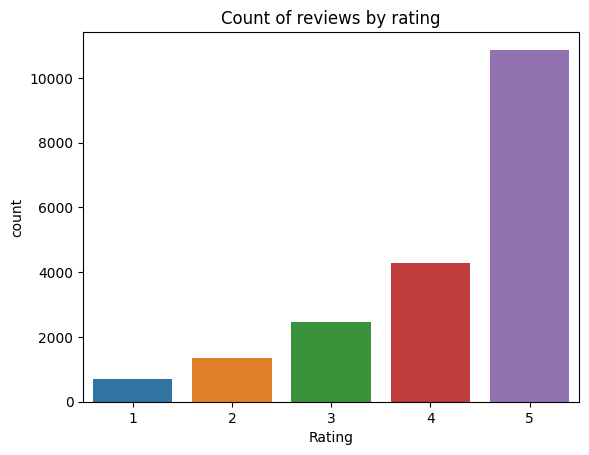

In [16]:
# Visualize rating distribution
sns.countplot(data=df, x='Rating')
plt.title('Count of reviews by rating')

In [17]:
# Count length of the reviews
df['Length'] = df['Review'].apply(len)
df.head()

,Rating,Review,Length
2,3,Some major design flaws I had such high hopes ...,524
3,5,"My favorite buy! I love, love, love this jumps...",141
4,5,Flattering shirt This shirt is very flattering...,209
5,2,Not for the very petite I love tracy reese dre...,512
6,5,Cagrcoal shimmer fun I aded this in my basket ...,517


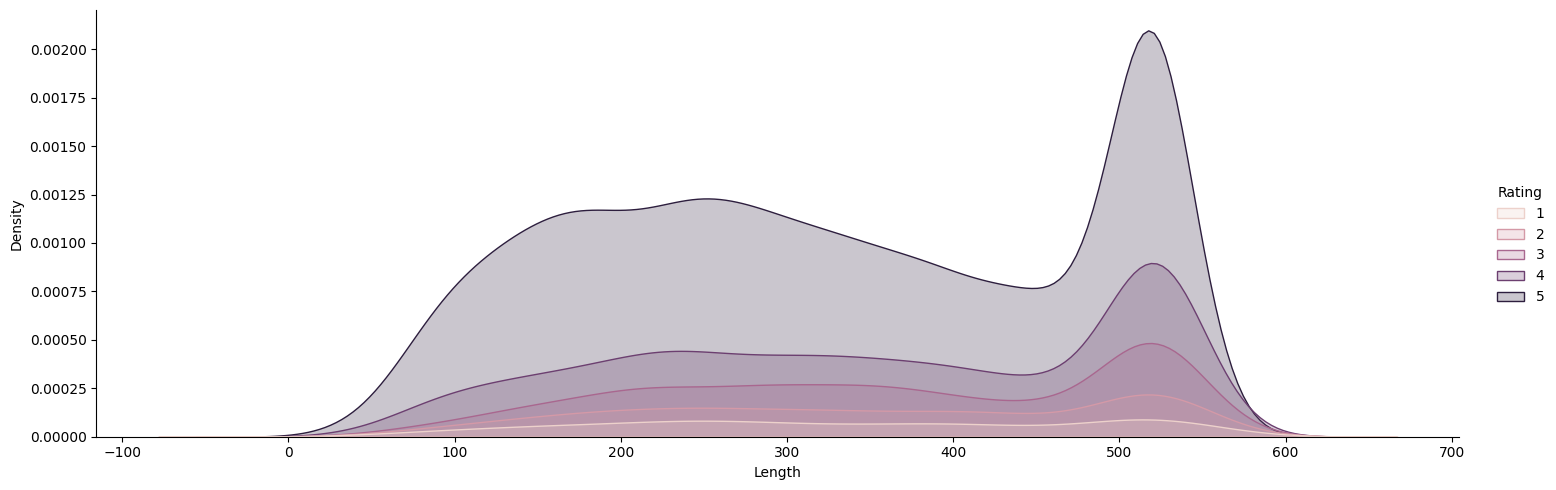

In [18]:
# Visualize length distribution based on the rating
sns.displot(data=df, x='Length', hue='Rating', kind='kde', fill=True, aspect=3)

**Text preprocessing**

In [19]:
# Define a function to clean the text
def clean_text(text):
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'(.)\1\1+', r"\1\1", text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [w for w in tokens if len(w) > 2]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens]

    text = ' '.join(tokens)
    return text

# Apply new function
df['Review'] = df['Review'].apply(clean_text)

In [20]:
# Find the most common words
all_words = ' '.join(df['Review']).lower().split()
word_counts = Counter(all_words)
top_words = word_counts.most_common(20)

print(top_words)

[('dress', 11700), ('fit', 9753), ('love', 9607), ('size', 8626), ('top', 8519), ('great', 7063), ('color', 6609), ('like', 6500), ('look', 6343), ('wear', 5905), ('fabric', 4642), ('would', 4495), ('small', 4388), ('cute', 4131), ('perfect', 4115), ('beautiful', 3872), ('really', 3665), ('flattering', 3581), ('little', 3496), ('one', 3451)]


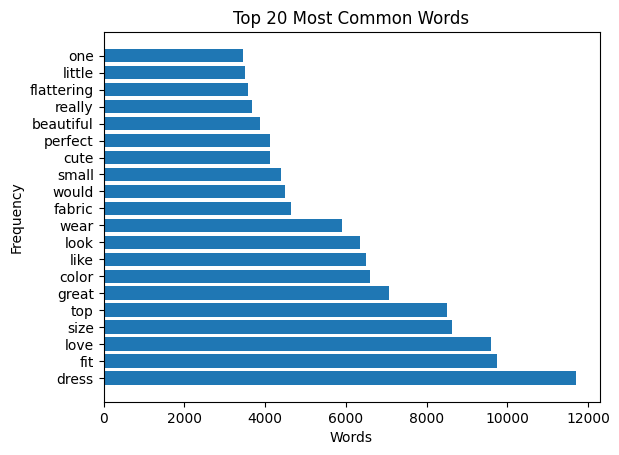

In [21]:
# Visualize most common words
fig, ax = plt.subplots()
ax.barh([word for (word, count) in top_words], [count for (word, count) in top_words])
ax.set_xlabel('Words')
ax.set_ylabel('Frequency')
ax.set_title('Top 20 Most Common Words')
plt.show()

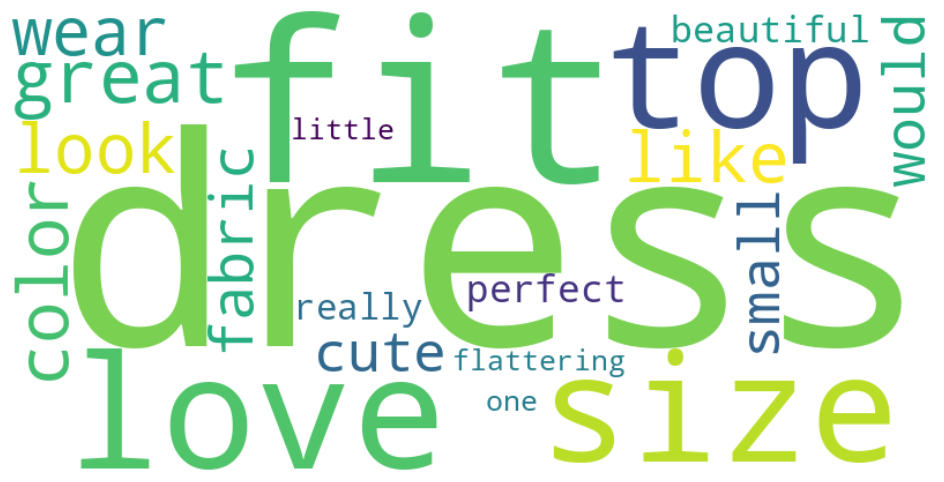

In [22]:
# Create a word cloud
wordcloud = WordCloud(width=800,
                      height=400,
                      background_color='white').generate_from_frequencies(dict(top_words))

# Plot the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Sentiment Analysis

In [23]:
# Define a function to classify the sentiment of a review
sia = SentimentIntensityAnalyzer()

def get_sentiment(review):
    scores = sia.polarity_scores(review)
    sentiment_score = scores['compound']
    if sentiment_score > 0.1:
        return 'positive'
    elif sentiment_score < -0.1:
        return 'negative'
    else:
        return 'neutral'

# Apply function on dataset copy
df2 = df.copy()
df2['Predicted_Sentiment'] = df2['Review'].apply(get_sentiment)

# Print the number of positive, negative, and neutral reviews
print("Number of positive reviews:", len(df2[df2['Predicted_Sentiment'] == 'positive']))
print("Number of negative reviews:", len(df2[df2['Predicted_Sentiment'] == 'negative']))
print("Number of neutral reviews:", len(df2[df2['Predicted_Sentiment'] == 'neutral']))

Number of positive reviews: 18925
Number of negative reviews: 521
Number of neutral reviews: 229


In [24]:
# Map the rating column to create new column true sentiment
df2['True_Sentiment'] = df2['Rating'].map({1: 'negative',
                                           2: 'negative',
                                           3: 'neutral',
                                           4: 'positive',
                                           5: 'positive'})

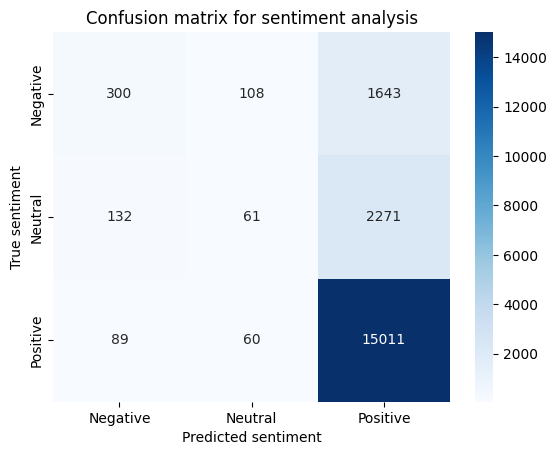

In [25]:
# Calculate confusion matrix
cm = confusion_matrix(df2['True_Sentiment'], df2['Predicted_Sentiment'])

# Create heatmap
labels = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted sentiment')
plt.ylabel('True sentiment')
plt.title('Confusion matrix for sentiment analysis')
plt.show()

In [26]:
print("\nClassification report:\n", classification_report(df2['True_Sentiment'],
                                                          df2['Predicted_Sentiment']))


Classification report:
               precision    recall  f1-score   support

    negative       0.58      0.15      0.23      2051
     neutral       0.27      0.02      0.05      2464
    positive       0.79      0.99      0.88     15160

    accuracy                           0.78     19675
   macro avg       0.55      0.39      0.39     19675
weighted avg       0.70      0.78      0.71     19675



# Prediction of Rating

In [27]:
# Define function for new column sentiment
positive = [4, 5]
neutral = [3]
negative = [1, 2]

def map_sentiment(rating):
    if rating in positive:
        return 2
    elif rating in neutral:
        return 1
    else:
        return 0

df['Sentiment']= df['Rating'].apply(map_sentiment)

In [28]:
# Prepare data for modeling
tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=10000, tokenizer = word_tokenize)
X = tfidf.fit_transform(df['Review'])
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=24)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


# Random Forest

In [29]:
# Build the model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

predicted_rf = rf.predict(X_test)

# Calculate accuracy and print classification report
accuracy_rf = accuracy_score(y_test, predicted_rf)
print('Accuracy:', accuracy_rf)
print('Classification Report:')
print(classification_report(y_test, predicted_rf))

Accuracy: 0.8013823947956902
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.27      0.39       495
           1       0.38      0.04      0.07       614
           2       0.81      0.99      0.89      3810

    accuracy                           0.80      4919
   macro avg       0.62      0.44      0.45      4919
weighted avg       0.74      0.80      0.74      4919



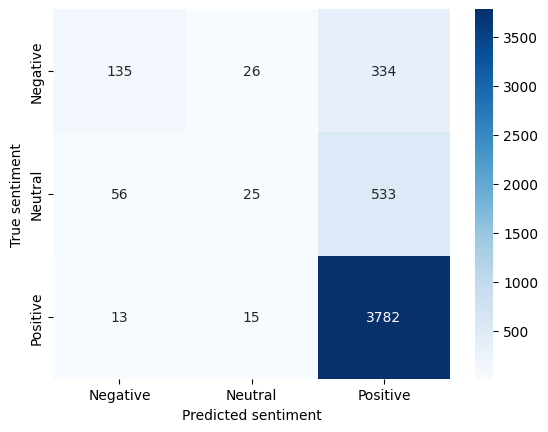

In [30]:
# Build confusion matrix
cm_rf = confusion_matrix(y_test, predicted_rf)

# Create heatmap
labels = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm_rf, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted sentiment')
plt.ylabel('True sentiment')
plt.show()

# Naive Bayes Multinominal

In [31]:
# Build the model
nb = MultinomialNB()
nb.fit(X_train, y_train)

predicted_nb = nb.predict(X_test)

# Calculate accuracy and print classification report
accuracy_nb = accuracy_score(y_test, predicted_nb)
print('Accuracy:', accuracy_nb)
print('Classification Report:')
print(classification_report(y_test, predicted_nb))

Accuracy: 0.8005692213864607
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.19      0.31       495
           1       0.46      0.08      0.14       614
           2       0.81      1.00      0.89      3810

    accuracy                           0.80      4919
   macro avg       0.67      0.42      0.45      4919
weighted avg       0.76      0.80      0.74      4919



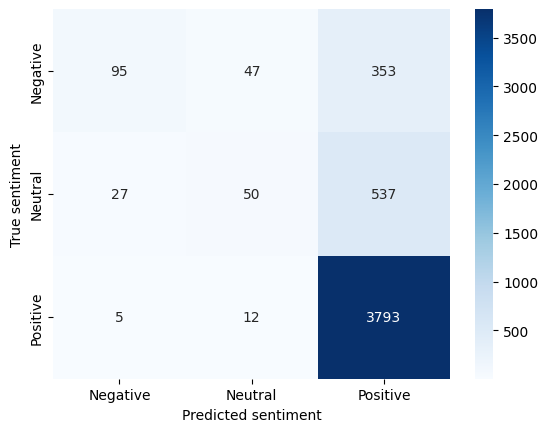

In [32]:
# Build confusion matrix
cm_nb = confusion_matrix(y_test, predicted_nb)

# Create heatmap
labels = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm_nb, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted sentiment')
plt.ylabel('True sentiment')
plt.show()

In [33]:
# Build the model
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

predicted_xgb = xgb.predict(X_test)

# Calculate accuracy and print classification report
accuracy_xgb = accuracy_score(y_test, predicted_xgb)
print('Accuracy:', accuracy_xgb)
print('Classification Report:')
print(classification_report(y_test, predicted_xgb))

Accuracy: 0.8229314901402724
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.46      0.53       495
           1       0.42      0.21      0.28       614
           2       0.87      0.97      0.92      3810

    accuracy                           0.82      4919
   macro avg       0.64      0.54      0.57      4919
weighted avg       0.79      0.82      0.80      4919



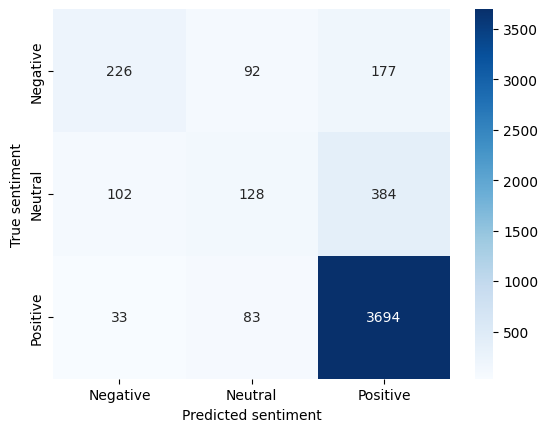

In [34]:
# Build confusion matrix
cm_xgb = confusion_matrix(y_test, predicted_xgb)

# Create heatmap
labels = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm_xgb, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted sentiment')
plt.ylabel('True sentiment')
plt.show()

In [35]:
# Build model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

predicted_lr = lr.predict(X_test)

# Calculate accuracy and print classification report
accuracy_lr = accuracy_score(y_test, predicted_lr)
print('Accuracy:', accuracy_lr)
print('Classification Report:')
print(classification_report(y_test, predicted_lr))

Accuracy: 0.832892864403334
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.48      0.55       495
           1       0.47      0.24      0.32       614
           2       0.87      0.97      0.92      3810

    accuracy                           0.83      4919
   macro avg       0.67      0.56      0.60      4919
weighted avg       0.80      0.83      0.81      4919



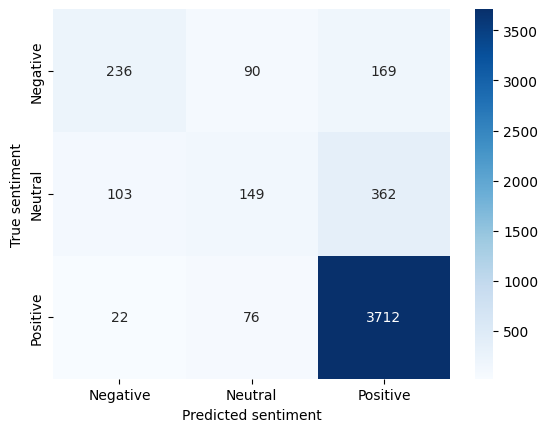

In [36]:
# Build confusion matrix
cm_lr = confusion_matrix(y_test, predicted_lr)

# Create heatmap
labels = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm_lr, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted sentiment')
plt.ylabel('True sentiment')
plt.show()

In [37]:
# Build model
svc = LinearSVC(random_state=42)
svc.fit(X_train, y_train)

predicted_svc = svc.predict(X_test)

# Calculate accuracy and print classification report
accuracy_svc = accuracy_score(y_test, predicted_svc)
print('Accuracy:', accuracy_svc)
print('Classification Report:')
print(classification_report(y_test, predicted_svc))

Accuracy: 0.8332994511079488
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.53      0.55       495
           1       0.45      0.32      0.38       614
           2       0.90      0.96      0.93      3810

    accuracy                           0.83      4919
   macro avg       0.65      0.60      0.62      4919
weighted avg       0.81      0.83      0.82      4919



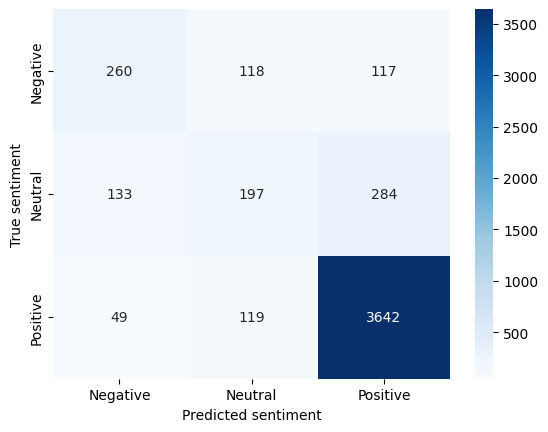

In [38]:
# Build confusion matrix
cm_svc = confusion_matrix(y_test, predicted_svc)

# Create heatmap
labels = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm_svc, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted sentiment')
plt.ylabel('True sentiment')
plt.show()

In [39]:
# Compare models performance
Models = ['Random Forest', 'Naive Bayes Multinominal', 'XGBoost', 'Logistic Regression', 'SVC']
Scores = [accuracy_rf, accuracy_nb, accuracy_xgb, accuracy_lr, accuracy_svc]
performance = pd.DataFrame(list(zip(Models, Scores)),
                          columns = ['Models', 'Accuracy_score'])\
                            .sort_values('Accuracy_score', ascending=False)
performance

,Models,Accuracy_score
4,SVC,0.833299
3,Logistic Regression,0.832893
2,XGBoost,0.822931
0,Random Forest,0.801382
1,Naive Bayes Multinominal,0.800569


# Text clustering for negative reviews

In [40]:
# Choose only negative reviews
df_neg = df[df['Rating'] <= 2]

# Convert text to numerical vectors using TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df_neg['Review'])

# Cluster the documents using K-Means algorithm
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=1, random_state=0)
kmeans.fit(X)

# Evaluate the performance of the clustering using adjusted Rand index
y_true = df_neg['Rating'].values
y_pred = kmeans.labels_
print('Adjusted Rand index:', adjusted_rand_score(y_true, y_pred))

Adjusted Rand index: -0.0010240571296709895


In [41]:
# Reduce the dimensionality of the vectors to 2 using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

In [42]:
# Print the top terms per cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(num_clusters):
    print(f"Cluster {i+1} top terms:", [terms[ind] for ind in order_centroids[i, :10]])
    print('-------')


Cluster 1 top terms: ['dress', 'like', 'fit', 'look', 'fabric', 'color', 'size', 'beautiful', 'material', 'love']
-------
Cluster 2 top terms: ['small', 'size', 'look', 'shirt', 'like', 'fit', 'short', 'really', 'ordered', 'big']
-------
Cluster 3 top terms: ['fabric', 'quality', 'color', 'sweater', 'like', 'look', 'fit', 'wear', 'pant', 'material']
-------


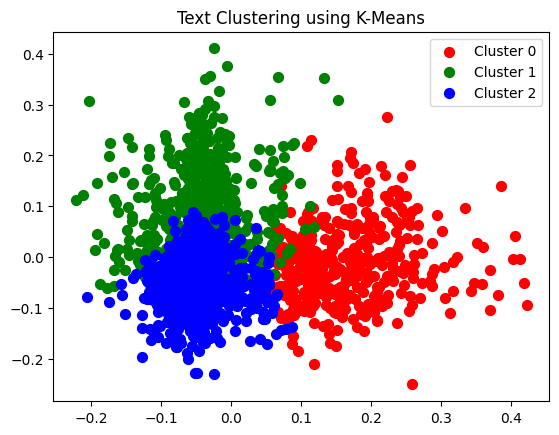

In [43]:
# Plot the clusters
colors = ['red', 'green', 'blue']
for i in range(num_clusters):
    plt.scatter(X_pca[kmeans.labels_ == i, 0], X_pca[kmeans.labels_ == i, 1], s=50, c=colors[i], label='Cluster {}'.format(i))
plt.legend()
plt.title('Text Clustering using K-Means')
plt.show()

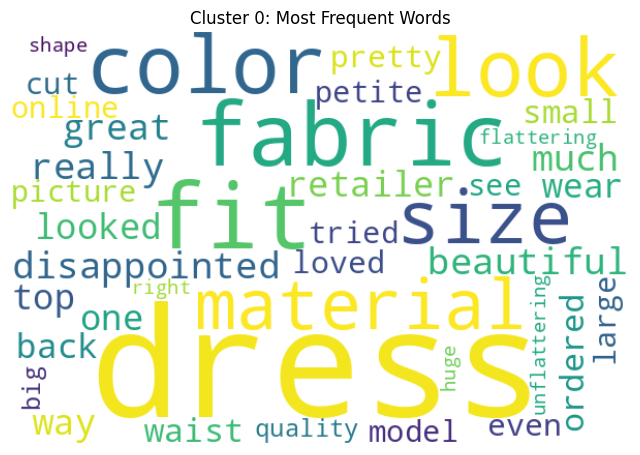

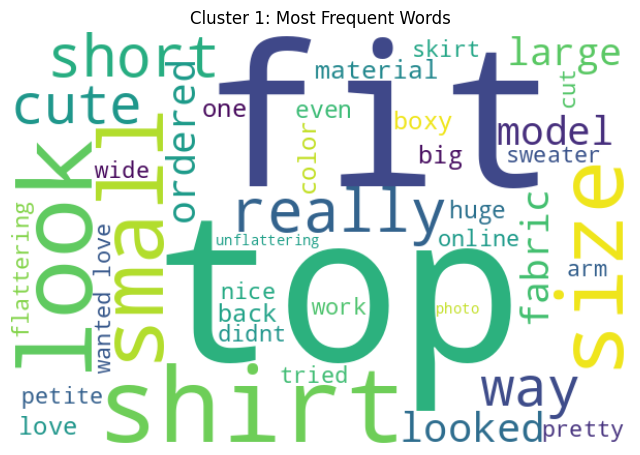

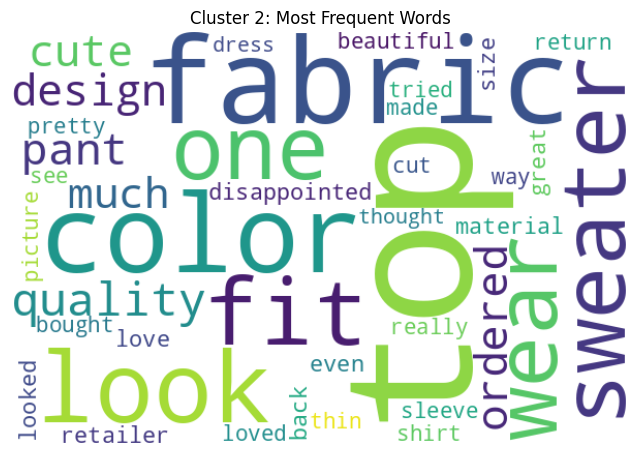

In [44]:
# Get the most frequent words in each cluster
top_words = 40
for i in range(num_clusters):
    cluster_reviews = df_neg['Review'][kmeans.labels_ == i]
    cluster_text = ' '.join(cluster_reviews)
    wordcloud = WordCloud(width=600, height=400, max_words=top_words, background_color='white').generate(cluster_text)
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Cluster {}: Most Frequent Words'.format(i))
    plt.show()